In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import GARCH, ARCH, Naive, AutoARIMA
from datasetsforecast.losses import mae
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
tickers = ['BTC-USD', 'NVDA', 'IBM'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1wk')
df.head()

[*********************100%%**********************]  3 of 3 completed


Price          Adj Close                               Close              \
Ticker           BTC-USD         IBM      NVDA       BTC-USD         IBM   
Date                                                                       
2018-01-01  16477.599609  114.265411  5.327616  16477.599609  155.344162   
2018-01-08  13772.000000  114.722481  5.515099  13772.000000  155.965576   
2018-01-15  11600.099609  114.181007  5.691448  11600.099609  155.229446   
2018-01-22  11786.299805  117.675995  6.018427  11786.299805  159.980881   
2018-01-29   8277.009766  111.832298  5.775791   8277.009766  152.036331   

Price                        High                                Low  \
Ticker         NVDA       BTC-USD         IBM     NVDA       BTC-USD   
Date                                                                   
2018-01-01  5.38500  17712.400391  155.736145  5.45125  13154.700195   
2018-01-08  5.57450  16537.900391  157.686417  5.65675  13105.900391   
2018-01-15  5.75275  14445.500000  163.604202  5.77725   9402.290039   
2018-01-22  6.08325  12040.299805  161.300186  6.08350  10129.700195   
2018-01-29  5.83800  11875.599609  160.984711  6.23175   7796.490234   

Price                                    Open                       \
Ticker             IBM     NVDA       BTC-USD         IBM     NVDA   
Date                                                                 
2018-01-01  146.787766  4.86250  14112.200195  147.705551  4.89450   
2018-01-08  154.588913  5.40000  16476.199219  155.506699  5.51000   
2018-01-15  154.206497  5.41725  13767.299805  157.839386  5.60125   
2018-01-22  154.024857  5.70250  11633.099609  154.407272  5.76075   
2018-01-29  151.883362  5.77925  11755.500000  160.086044  6.06850   

Price             Volume                        
Ticker           BTC-USD       IBM        NVDA  
Date                                            
2018-01-01  123814400000  27610321  2433712000  
2018-01-08  106022199296  23618471  2726828000  
2018-01-15   97932879872  57463056  2258768000  
2018-01-22   64691999232  30001790  2532384000  
2018-01-29   60810019840  23198397  2742212000

In [4]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,BTC-USD,NVDA,IBM
0,2018-01-01,16477.599609,5.327616,114.265411
1,2018-01-08,13772.000000,5.515099,114.722481
2,2018-01-15,11600.099609,5.691448,114.181007
3,2018-01-22,11786.299805,6.018427,117.675995
4,2018-01-29,8277.009766,5.775791,111.832298


In [5]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,BTC-USD,2018-01-01,16477.599609
1,BTC-USD,2018-01-08,13772.000000
2,BTC-USD,2018-01-15,11600.099609
3,BTC-USD,2018-01-22,11786.299805
4,BTC-USD,2018-01-29,8277.009766
...,...,...,...
778,IBM,2022-11-28,138.976425
779,IBM,2022-12-05,137.462097
780,IBM,2022-12-12,131.021317
781,IBM,2022-12-19,132.414139


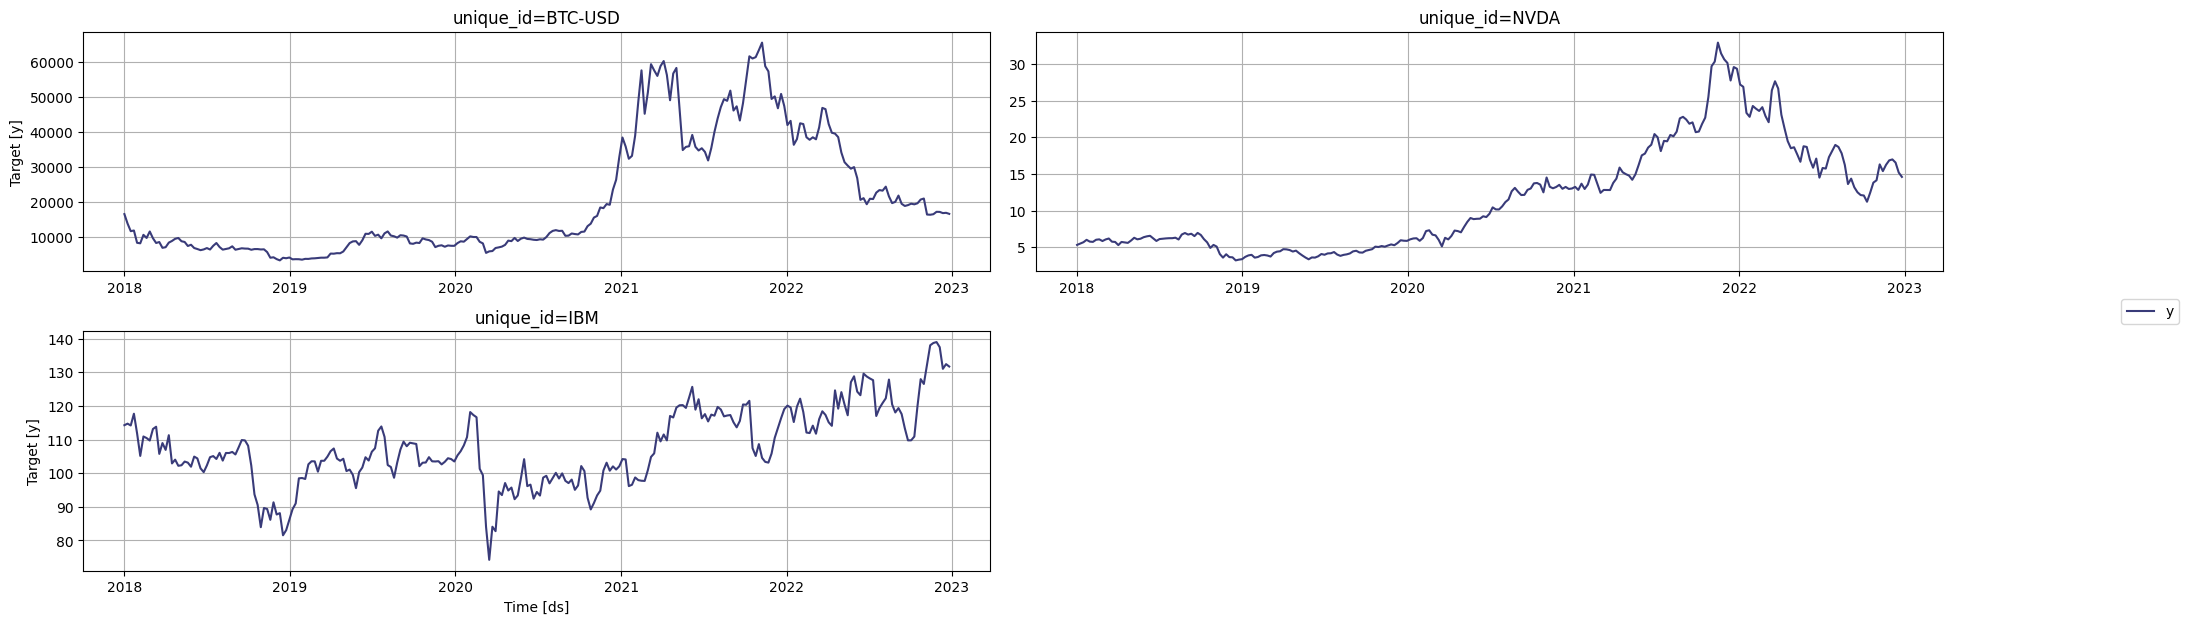

In [6]:
StatsForecast.plot(prices)

In [7]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns

,unique_id,ds,y
0,BTC-USD,2018-01-01,NaN
1,BTC-USD,2018-01-08,-0.179364
2,BTC-USD,2018-01-15,-0.171624
3,BTC-USD,2018-01-22,0.015924
4,BTC-USD,2018-01-29,-0.353456
...,...,...,...
778,IBM,2022-11-28,0.002020
779,IBM,2022-12-05,-0.010956
780,IBM,2022-12-12,-0.047988
781,IBM,2022-12-19,0.010574


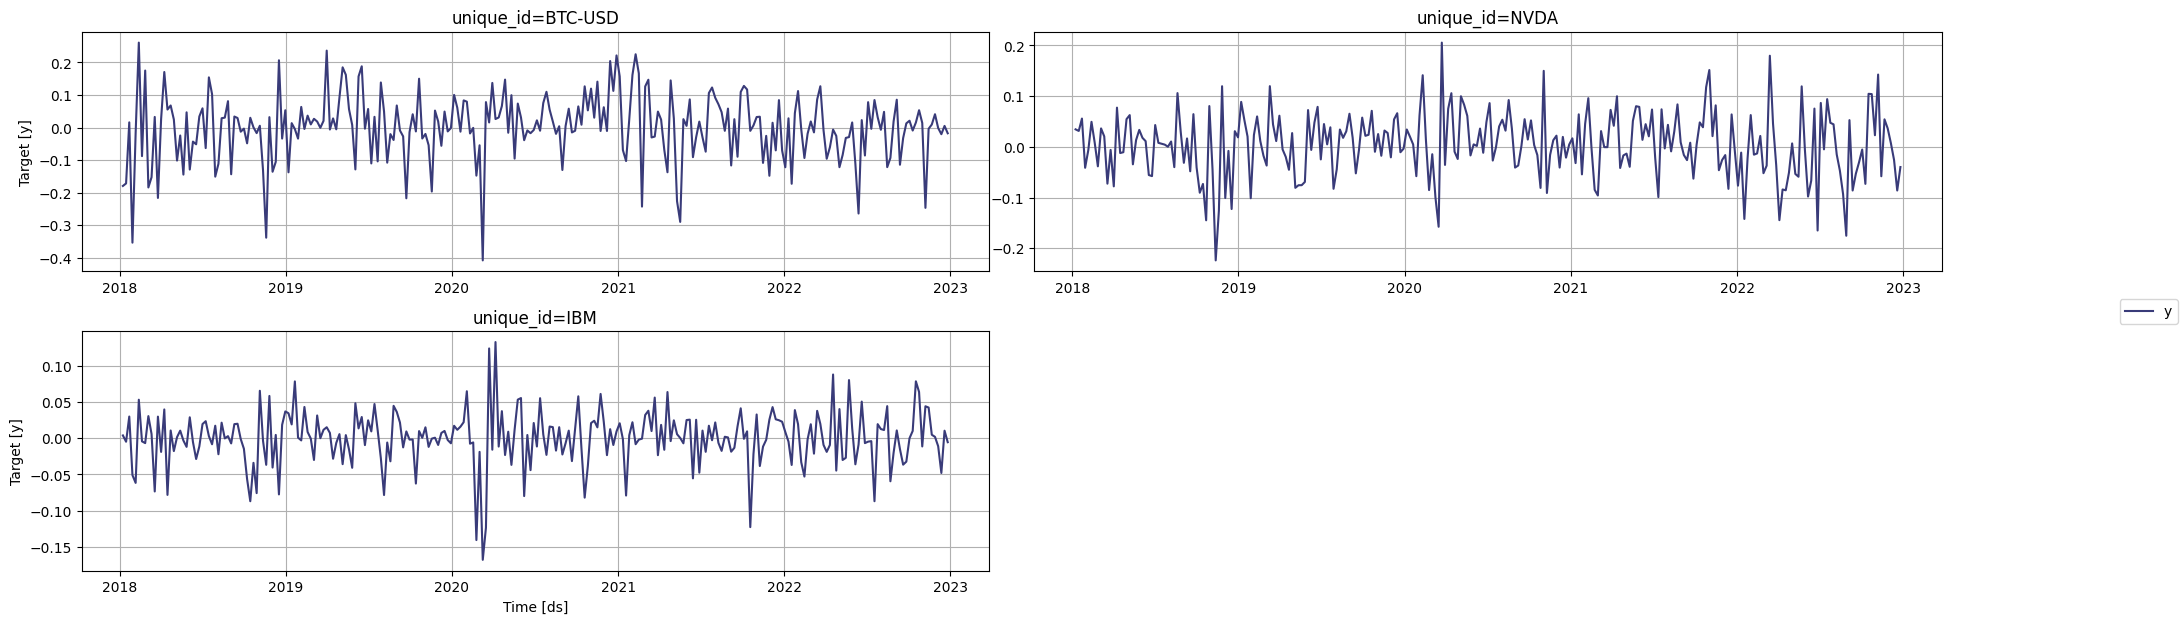

In [8]:
StatsForecast.plot(returns)

In [9]:
models = [ARCH(1), ARCH(2), GARCH(1,1), GARCH(1,2), GARCH(2,2), GARCH(2,1), AutoARIMA(), Naive()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'W',
    n_jobs = -1
)

In [10]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [11]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
0,BTC-USD,2022-10-10,2022-10-03,-0.009213,0.164645,0.273852,0.309043,0.271568,0.139465,0.287699,0.001642,0.020906
1,BTC-USD,2022-10-17,2022-10-03,0.015394,-0.064982,-0.106918,-0.121610,-0.105753,-0.059563,-0.112593,0.000000,0.020906
2,BTC-USD,2022-10-24,2022-10-03,0.053173,-0.053908,-0.092780,-0.101341,-0.088828,-0.057770,-0.097848,0.000000,0.020906
3,BTC-USD,2022-10-31,2022-10-24,0.013998,0.163971,0.140044,0.259298,0.285944,0.140049,0.293672,0.004330,0.053173
4,BTC-USD,2022-11-07,2022-10-24,-0.246582,-0.065095,-0.061277,-0.100648,-0.111606,-0.061282,-0.115101,0.000000,0.053173


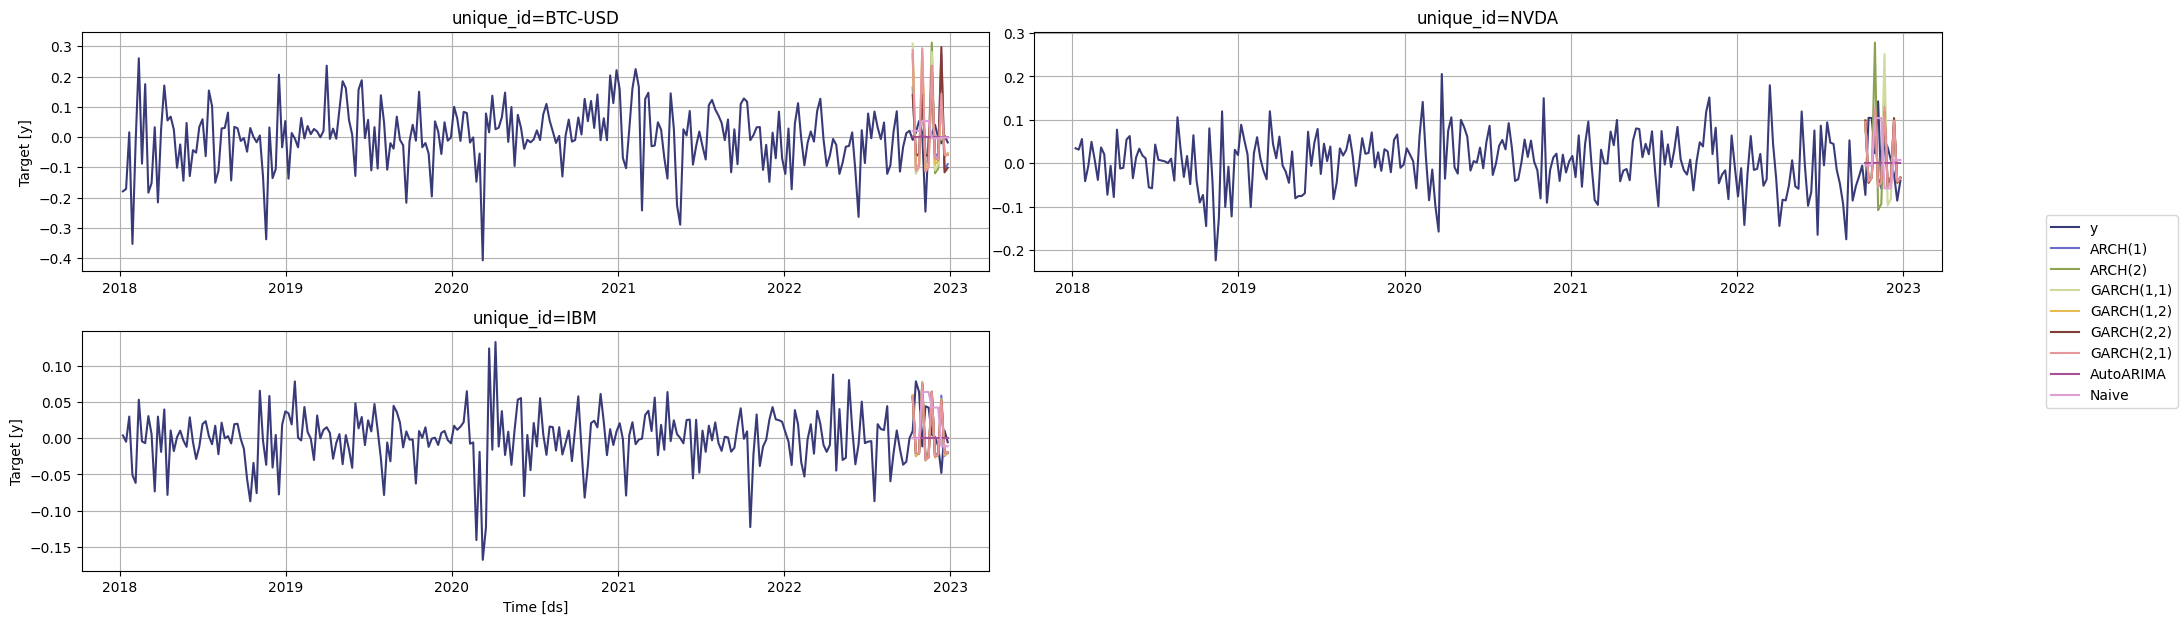

In [12]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [13]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae*100

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
unique_id,,,,,,,,
BTC-USD,12.784785,14.597978,15.620853,14.534415,13.595650,14.662397,3.604335,4.710778
IBM,5.784296,5.880682,5.904482,5.922176,5.861530,5.861454,2.778139,3.882149
NVDA,9.209880,11.441940,11.371158,9.614700,9.612279,9.655562,6.292783,8.457958
